# Main goal: check if small cells/blobs are typical for each structure or not

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/

In [4]:
stack = 'MD589'
pixel_size = 0.46
pixel_area = pixel_size ** 2
patch_size = 448
# patch_half_size = patch_size / 2
# stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
# crop_0_min = 8000
# crop_0_max = 11000
# crop_1_min = 8000
# crop_1_max = 12000

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_0_min = 0
crop_1_min = 0
crop_1_max, crop_0_max = metadata_cache['image_shape'][stack]
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min
crop_image_width = crop_1_max - crop_1_min
crop_image_height = crop_0_max - crop_0_min

# patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
# patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
# patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
# patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
# patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
# patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

# Load images

In [5]:
# Set examine section number range and download from S3 if not available
img_filename = []
cell_orientations = []
cell_centroids = []
cell_numbers = []
cell_contour = []
cell_global_coord = []
secIndexList = range(152, 154)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))

    cell_centroids.append(load_cell_data('centroid',stack=stack,sec=secIndexList[tempIndex1]))
    cell_numbers.append(cell_centroids[tempIndex1].shape[0])
    cell_global_coord.append(load_cell_data('coords', stack=stack, sec=secIndexList[tempIndex1]))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue

Image file is already available. 
Image file is already available. 


In [6]:
option_rescale_grayscale = True
option_inverse_color = False
# secIndex = 0

n_images = len(img_filename)
im_cropped = []
im_rescale = []
for imIndex in range(n_images):
    im_cropped.append(img_as_ubyte(rgb2gray(imread(img_filename[imIndex])[crop_0_min:crop_0_max, crop_1_min:crop_1_max])))
    if option_rescale_grayscale:
        im_rescale.append(fun_rescale_grayscale_image(im_cropped[imIndex],invcol=option_inverse_color))

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


## Reconstruct labeled images from detected cell dataset

In [7]:
oriImL1,oriImL0 = metadata_cache['image_shape'][stack]

option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = []
im_label = []
im_BW = []
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSecIndex in range(n_images):
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSecIndex],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label.append(temp_im_label)
    im_BW.append(temp_im_label>0)
    im_blob_prop[secIndexList[tempSecIndex]]  = temp_im_blob_prop
    
n_blobs = map(len, im_blob_prop.values())

In [137]:
secIdx = 0
sec = secIndexList[secIdx]
props = ['area', 'moments_hu', 'eccentricity','perimeter']
blob_prop_dic = {}
for prop in props:
    blob_prop_dic[prop] = np.array([im_blob_prop[sec][blobID][prop] for blobID in range(n_blobs[secIdx])])

blob_prop_dic['compactness'] = blob_prop_dic['perimeter'] ** 2 / blob_prop_dic['area'] / (4*Pi)

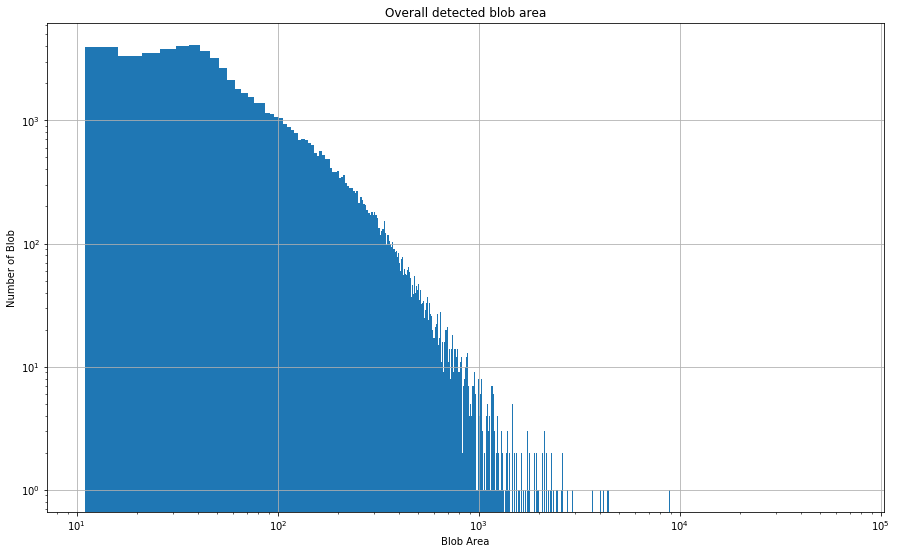

In [55]:
max_blob_area = np.max(cell_area_0)
min_blob_area = np.min(cell_area_0)
plt.figure(figsize=(15,9))
plt.hist(cell_area_0,range=(min_blob_area,max_blob_area),bins=np.int((max_blob_area - min_blob_area)/5));
plt.yscale('log', nonposy='clip')
plt.xscale('log')
plt.xlabel('Blob Area')
plt.ylabel('Number of Blob')
plt.title('Overall detected blob area')
plt.grid()

The area of the smallest and largest detected blob are 11 and 67103, respectively. The number of small blobs is much more than the number of large blobs (area ~ 1000). There is a peak at 36. The number of large blobs are much less than the number of small blobs. Except the peak at 36, there are no other significant peak and the reason is unknown. 

Detected blobs with area around this peak are either small cells or fragments. If we can confirm they are every where in the brain(stem) and cannot provide typical features in different annotated structure, then they can be eliminated when we do the blob matching. The problems are:
1. If they are everywhere, how to justify this argument by quantitative measurement? 
    * Analyze the features of these small blobs and plot their feature distribution through the brain?
2. How to set the threshold of size for elimination?
    * There are not obvious "boundary" between large blobs and small blobs

For blob area larger than 2000, we are pretty sure that most of the blob are not single cells, as shown in the following images.

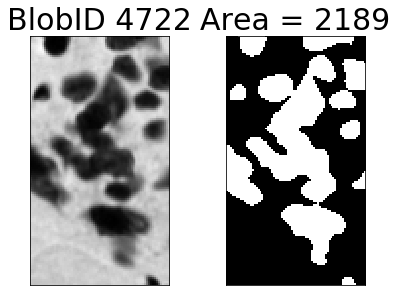

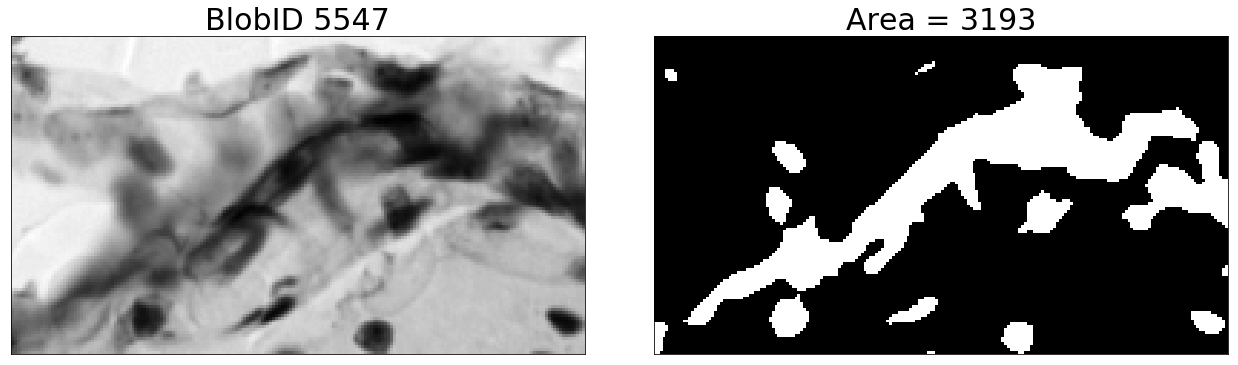

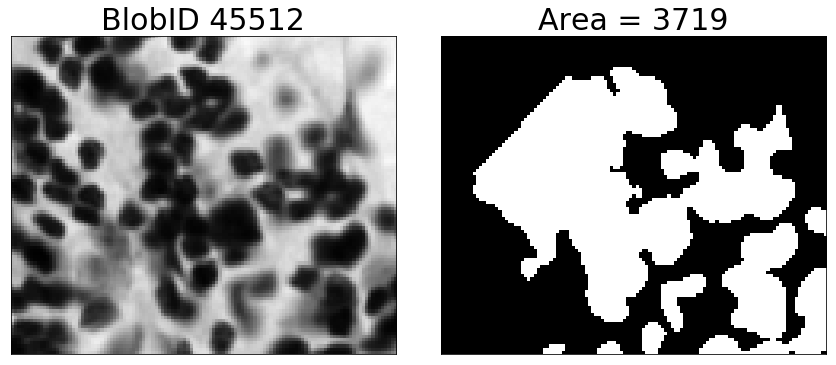

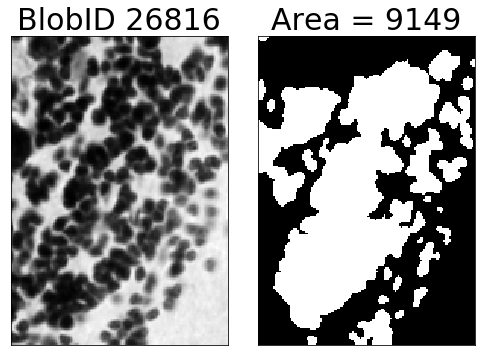

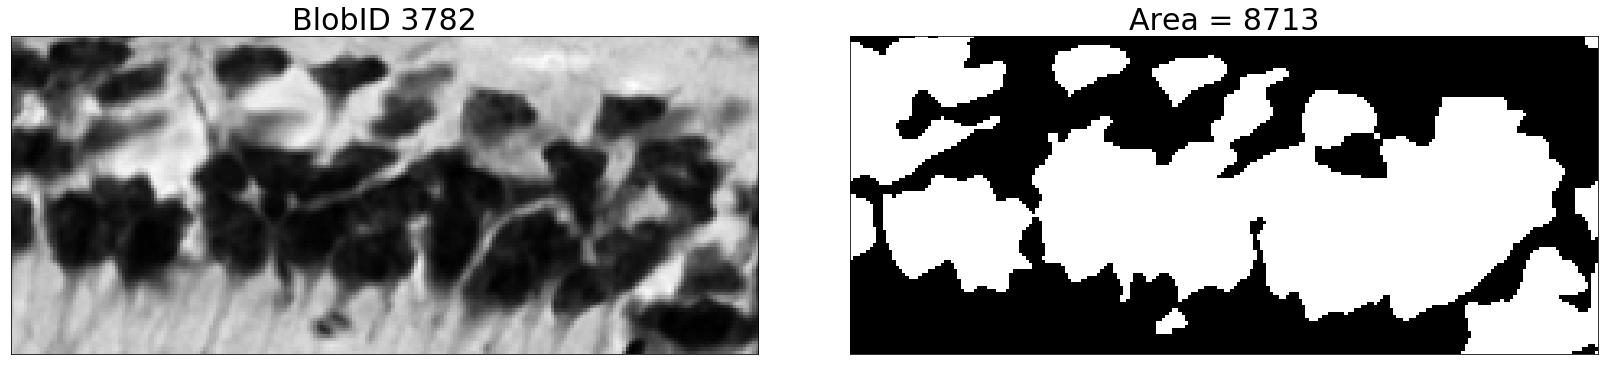

In [62]:
# Visualize large blobs (size between 9000 and 10000 pixels)
# Conclusion: blob size between 9000 and 10000 piexls are definitely not single cells
cell_idx_L2000 = np.where(np.logical_and(cell_area_0>2000, cell_area_0<=10000))[0]
margin = 10
for blobID in np.random.choice(cell_idx_L2000,5):
    display_images_in_grids([fun_crop_images(im_cropped[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max),
                            fun_crop_images(im_BW[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max)]
                            ,nc=2, cmap=plt.cm.gray, titles=['BlobID %d'%blobID,'Area = %d'%im_blob_prop[sec][blobID]['area']])

After eliminating the blobs with area larger than 2000, the area histroram is plot with a linear x-axis:

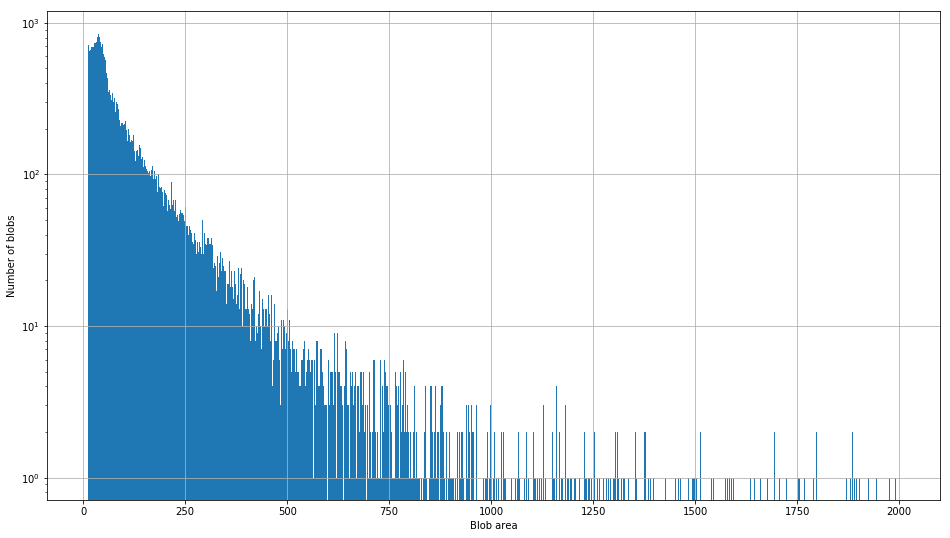

In [20]:
# Delete extremely large bolbs:
plt.figure(figsize=(16,9))
cell_area_cutoff = 2000
cell_area = cell_area_0[cell_area_0<cell_area_cutoff]
plt.hist(cell_area,range=(min_blob_area,cell_area_cutoff),bins=np.int((cell_area_cutoff - min_blob_area)));
plt.yscale('log', nonposy='clip')
plt.xlabel('Blob area')
plt.ylabel('Number of blobs')
# plt.xscale('log')
plt.grid()

In [88]:
im_value_max = 1000
stat_size_max = 1000
fig_size_dist = np.array(im_BW[secIdx].copy(),np.int16)
# fig_size_dist[fig_size_dist==1] = im_value_max
# fig_size_dist[fig_size_dist==0] = -im_value_max
fig_size_dist[fig_size_dist==1] = 0

In [89]:
# cell_idx_vis = np.where(cell_area_0<stat_size_max)[0]
cell_idx_vis = np.where(np.logical_and(cell_area_0> 100, cell_area_0 < 2000))[0]
for blobID in cell_idx_vis:
    blob_coords = im_blob_prop[sec][blobID]['coords']
    fig_size_dist[blob_coords[:,0],blob_coords[:,1]] = im_blob_prop[sec][blobID]['area']

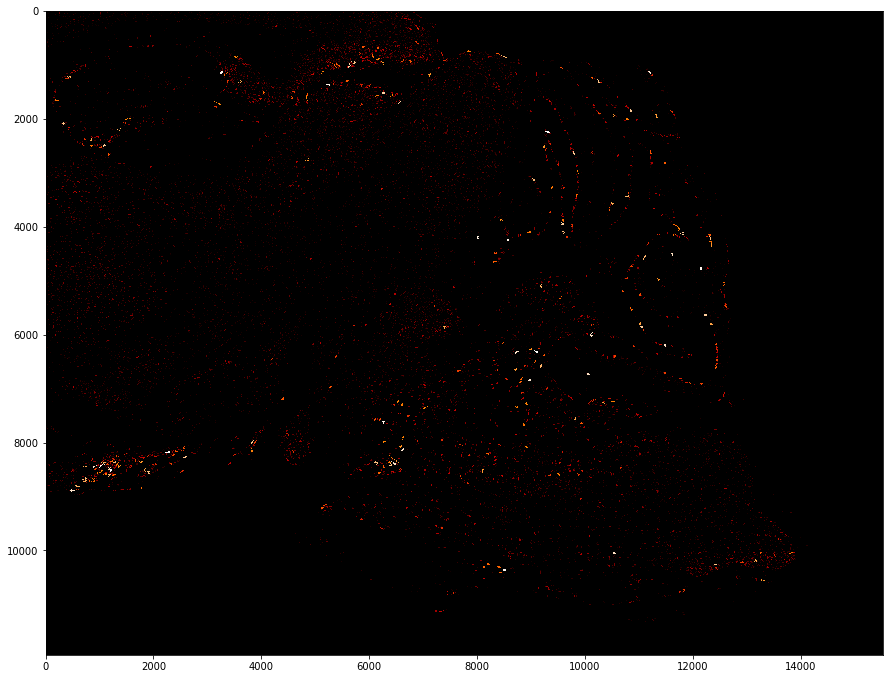

In [93]:
plt.figure(figsize=(15,15))
plt.imshow(fig_size_dist,cmap=plt.cm.gist_heat)

In [91]:
display_image(fun_rescale_grayscale_image(fig_size_dist))

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

Some of the detected blobs are certainly not single cells, but the overlap of many cells. These blobs generally has complicated boundary. Here we use `compactness` defined as:

$$\frac{Perimeter^2}{Area}$$

which can characterize the complicated boundary. For some simple shape, we have:
 * Disk: 4$\pi$
 * Square: 16
 * Rectangle: $8 + 4(\frac ab + \frac ba)$

The smallest number of compactness is $4\pi$, which is given by disk. However, the perimeters and area here are measured based on pixels. Therefore, we can get blob with this feature lower than $4\pi$ when the size of blob is small (typically below 100 pixels), as shown in the following scatter plot.  

In [52]:
Pi = 3.1415926

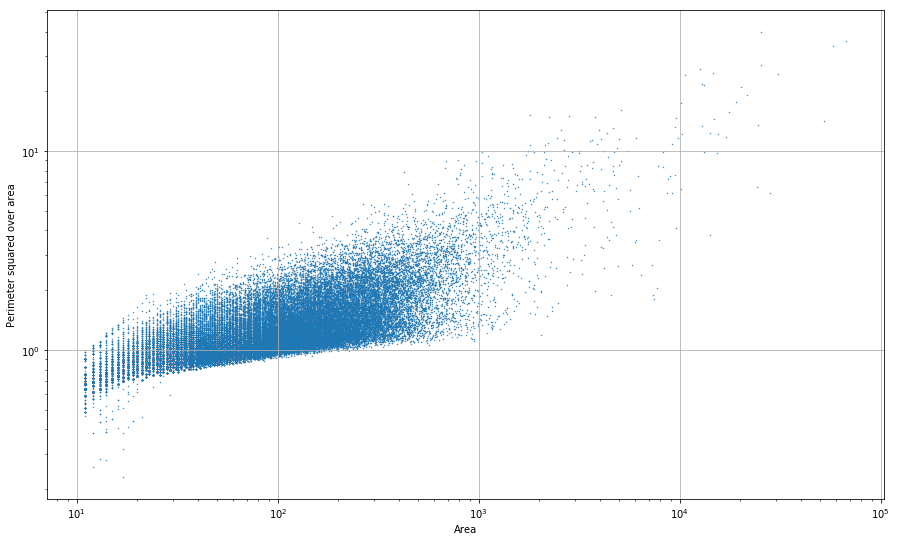

In [135]:
plt.figure(figsize=(15,9))
plt.scatter(blob_prop_dic['area'], periSqd2Area,s=0.2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Area')
plt.ylabel('Perimeter squared over area')
plt.grid()

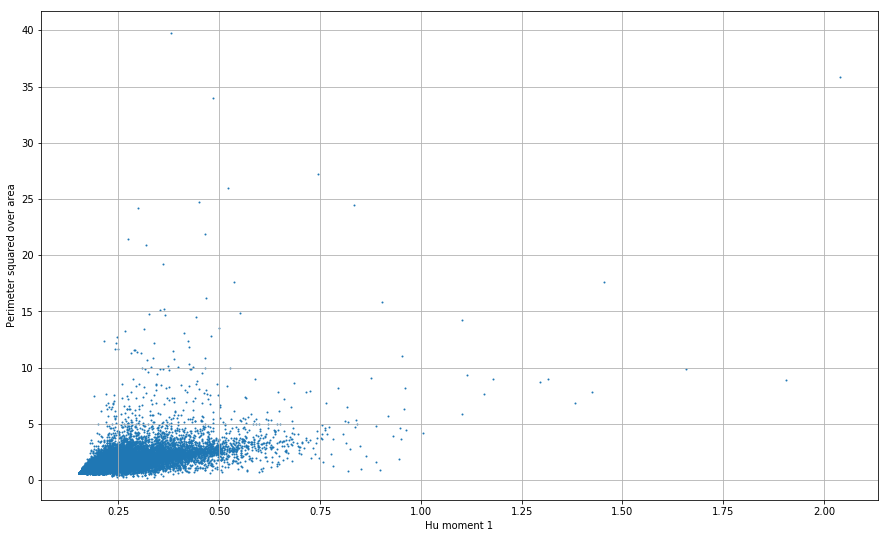

In [134]:
plt.figure(figsize=(15,9))
plt.scatter(blob_prop_dic['moments_hu'][:,0], periSqd2Area,s=1)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Hu moment 1')
plt.ylabel('Perimeter squared over area')
plt.grid()

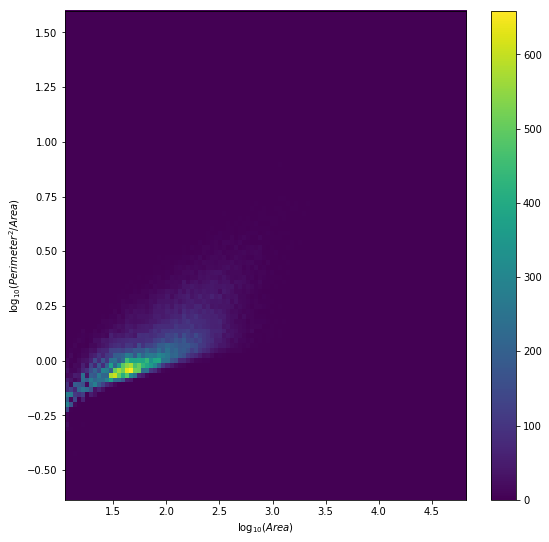

In [194]:
plt.figure(figsize=(9,9))
plt.hist2d(np.log10(blob_prop_dic['area']),np.log10(periSqd2Area),bins=100);
plt.xlabel('$\log_{10}(Area)$')
plt.ylabel('$\log_{10}(Perimeter^2/Area)$')
plt.colorbar()

The following histrogram shows the value of the compactness for all the detected blobs in section 152. 

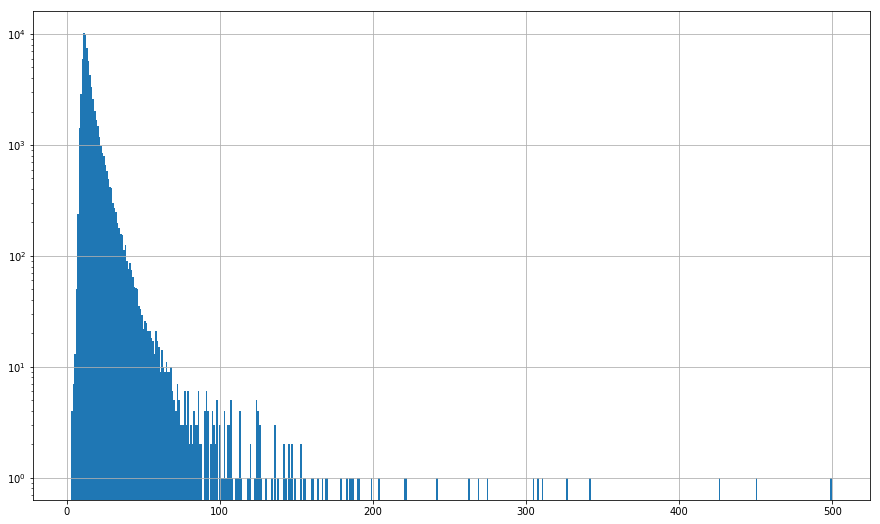

In [79]:
plt.figure(figsize=(15,9))
plt.hist(periSqd2Area,bins=np.int((np.max(periSqd2Area) - np.min(periSqd2Area)/3)))
# plt.xscale('log')
plt.yscale('log')
plt.grid()

# Finding threshold to eliminate large blobs that consist of many cells

In section 152, all of the blobs with compactness larger than 5 and area small than 1000 are aggregations of multiple cells. Manually checked. 

Most of the blobs with compactness in (0,1.5) and area in (1000, +\inf) looks like a single cell. Blob 18601 probably is consist of 2 cells, but it can be eliminated by typical blob collection. Results shown as the following list of cropped images.Manually checked. 

Here we choose the following threshold to eliminate detected blobs that consists of many cells: 
compactness < 2, area < 3000

In [223]:
tempIdx_cpL50 = np.where(blob_prop_dic['compactness']>5)[0];
tempIdx_cpL50_AS1000 = np.where(np.logical_and.reduce(np.row_stack(
    (blob_prop_dic['compactness']>2,blob_prop_dic['compactness']<2.5,blob_prop_dic['area']>1000,blob_prop_dic['area']<500000))))[0];
print('Total number of blobs found: %d'%len(tempIdx_cpL50_AS1000))

Total number of blobs found: 43


Blob ID 4152	 Area 1168.000000	 Compactness 2.397308	 Moments_hu_1 0.268317	 Moments_hu_2 0.031261


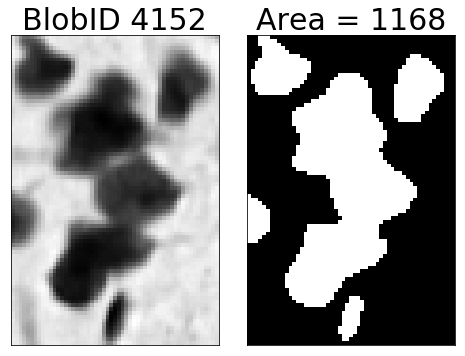

Blob ID 6518	 Area 1112.000000	 Compactness 2.411790	 Moments_hu_1 0.197573	 Moments_hu_2 0.006663


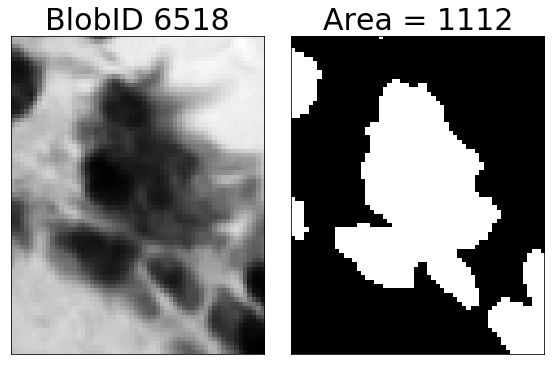

Blob ID 7349	 Area 1113.000000	 Compactness 2.215341	 Moments_hu_1 0.261967	 Moments_hu_2 0.033521


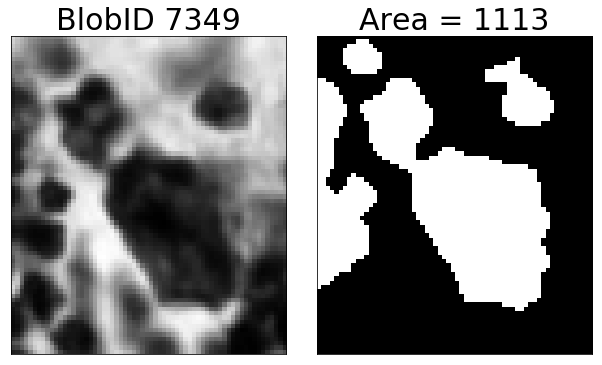

Blob ID 9690	 Area 1105.000000	 Compactness 2.108166	 Moments_hu_1 0.235336	 Moments_hu_2 0.020668


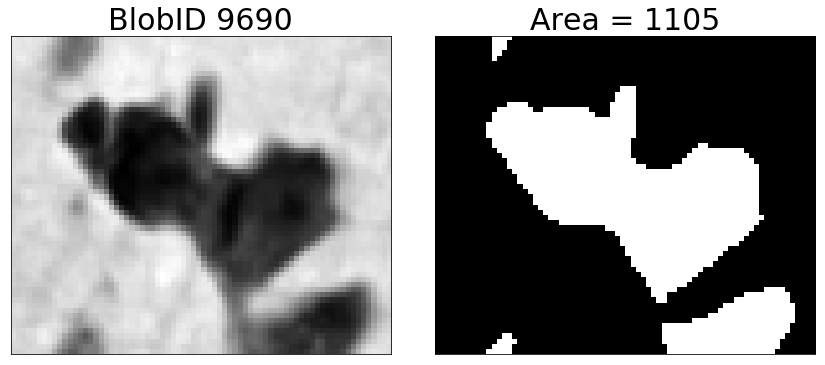

Blob ID 11306	 Area 1781.000000	 Compactness 2.228701	 Moments_hu_1 0.201699	 Moments_hu_2 0.004307


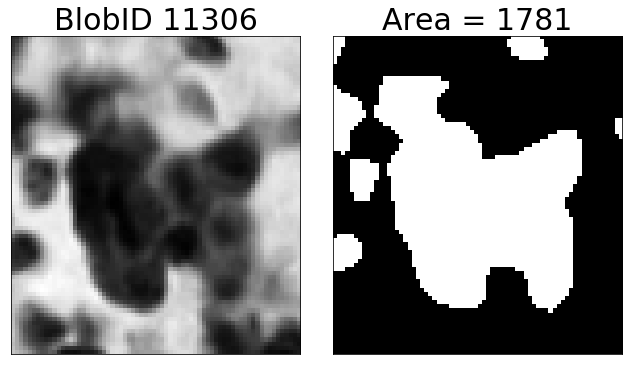

Blob ID 11437	 Area 6394.000000	 Compactness 2.392939	 Moments_hu_1 0.206417	 Moments_hu_2 0.008899


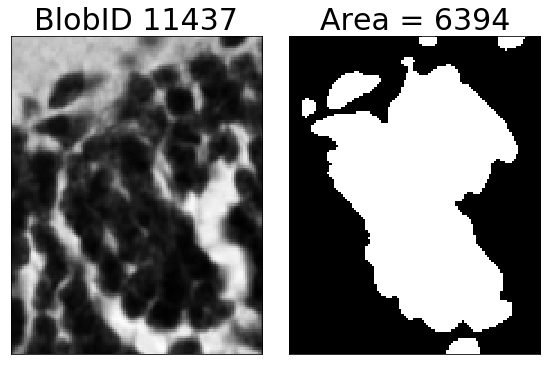

Blob ID 11563	 Area 1181.000000	 Compactness 2.181312	 Moments_hu_1 0.239864	 Moments_hu_2 0.024260


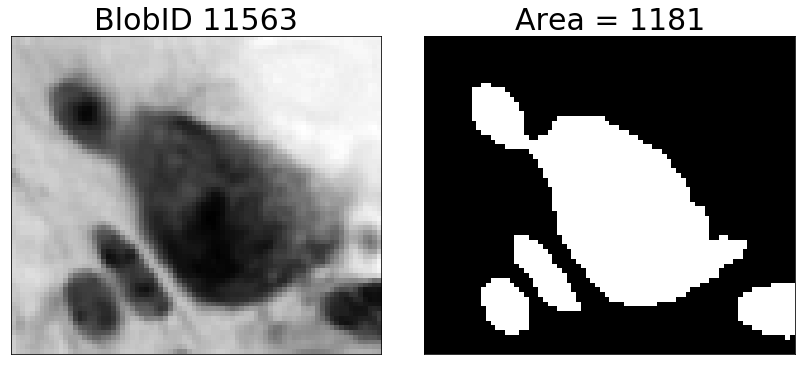

Blob ID 15376	 Area 7702.000000	 Compactness 2.065226	 Moments_hu_1 0.207481	 Moments_hu_2 0.011654


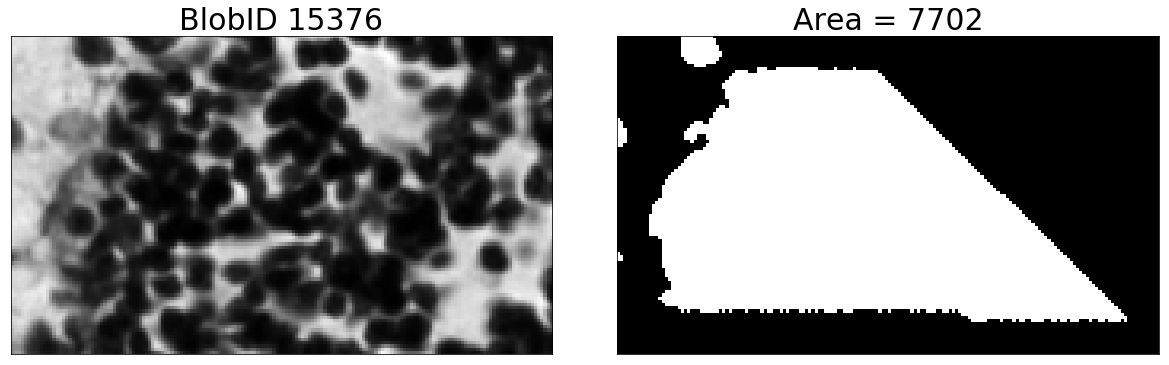

Blob ID 16056	 Area 1781.000000	 Compactness 2.217854	 Moments_hu_1 0.208998	 Moments_hu_2 0.010184


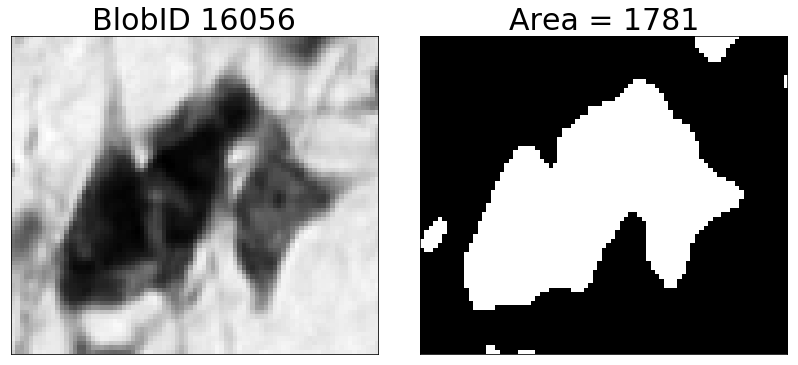

Blob ID 16927	 Area 1774.000000	 Compactness 2.073447	 Moments_hu_1 0.208816	 Moments_hu_2 0.009417


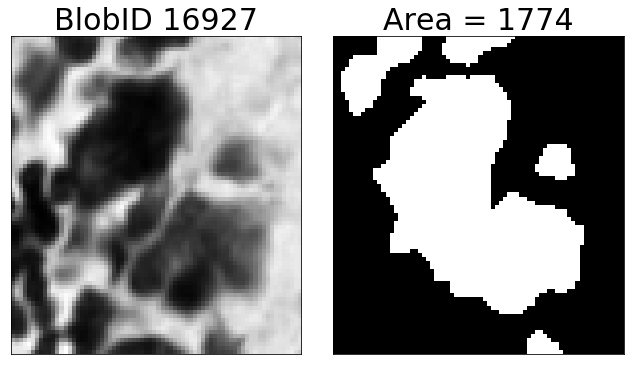

Blob ID 25336	 Area 1182.000000	 Compactness 2.375046	 Moments_hu_1 0.250399	 Moments_hu_2 0.030751


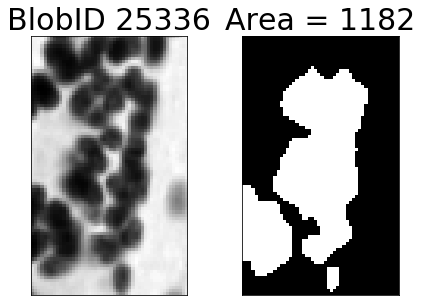

Blob ID 25492	 Area 2751.000000	 Compactness 2.133715	 Moments_hu_1 0.229350	 Moments_hu_2 0.017840


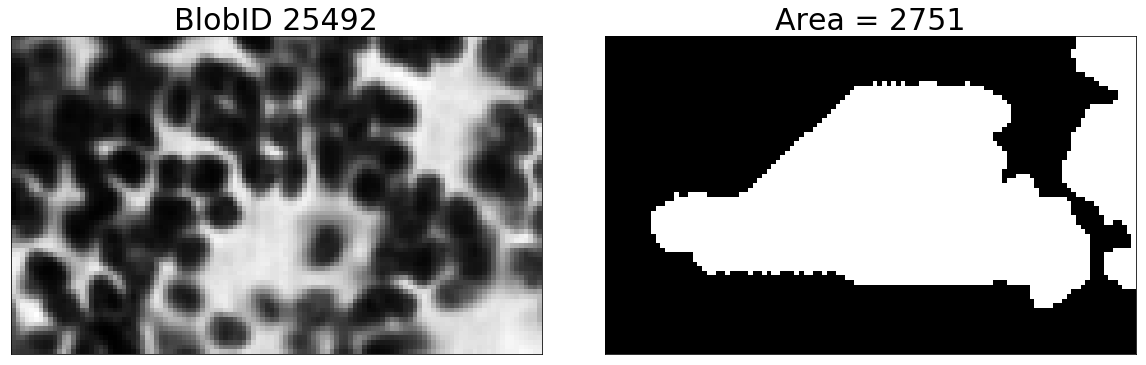

Blob ID 29912	 Area 1574.000000	 Compactness 2.349662	 Moments_hu_1 0.203200	 Moments_hu_2 0.007312


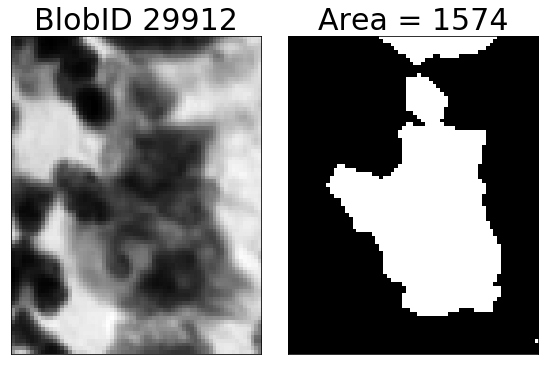

Blob ID 32655	 Area 1957.000000	 Compactness 2.382107	 Moments_hu_1 0.192637	 Moments_hu_2 0.004928


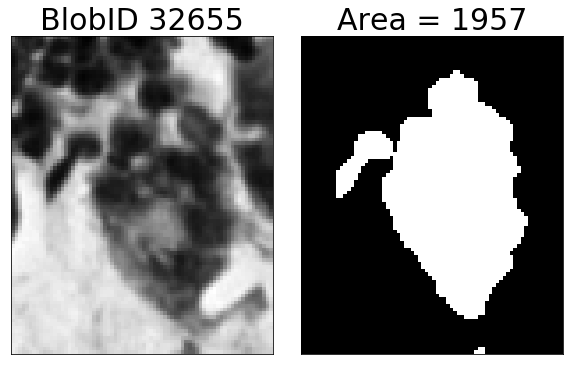

Blob ID 40552	 Area 1629.000000	 Compactness 2.319950	 Moments_hu_1 0.239117	 Moments_hu_2 0.015428


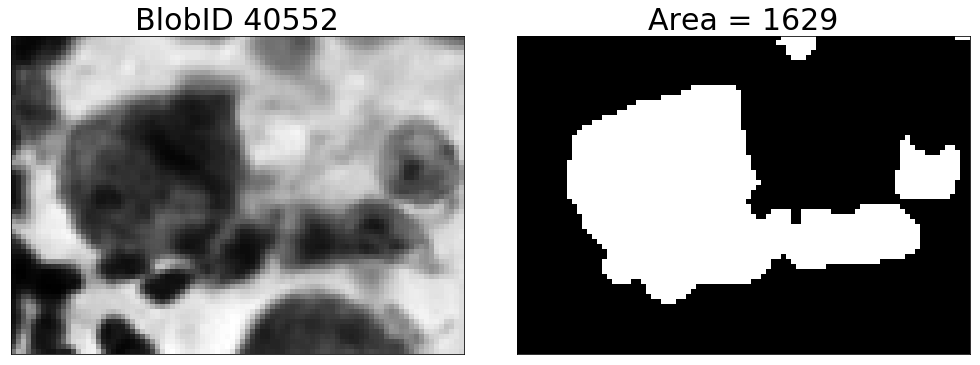

Blob ID 40712	 Area 1182.000000	 Compactness 2.437248	 Moments_hu_1 0.358220	 Moments_hu_2 0.092507


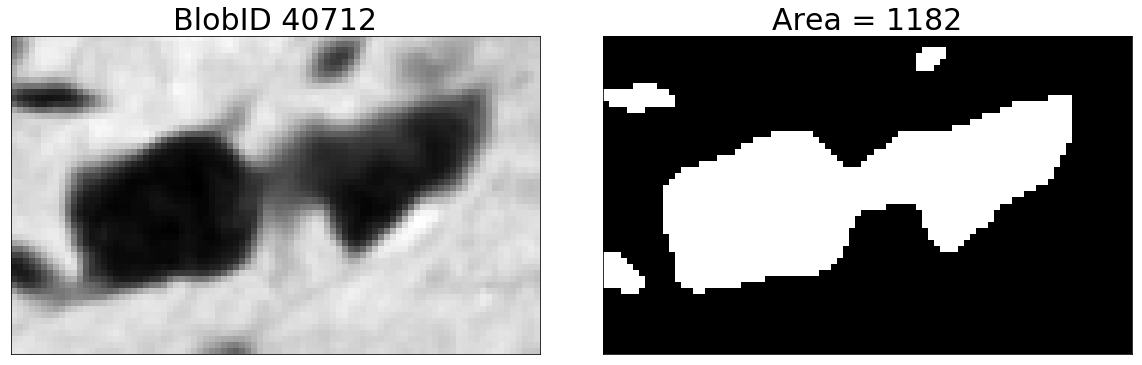

Blob ID 40807	 Area 1103.000000	 Compactness 2.030973	 Moments_hu_1 0.273234	 Moments_hu_2 0.042659


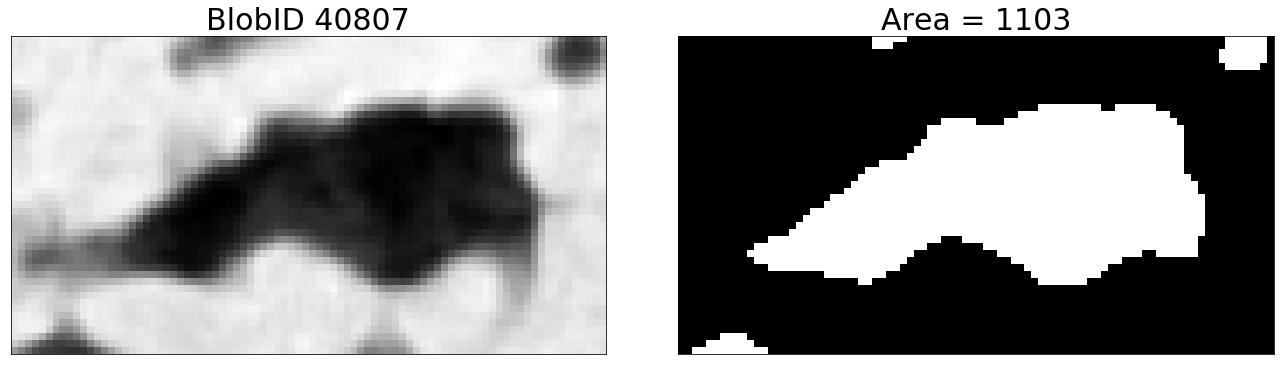

Blob ID 43188	 Area 1885.000000	 Compactness 2.025406	 Moments_hu_1 0.193775	 Moments_hu_2 0.008012


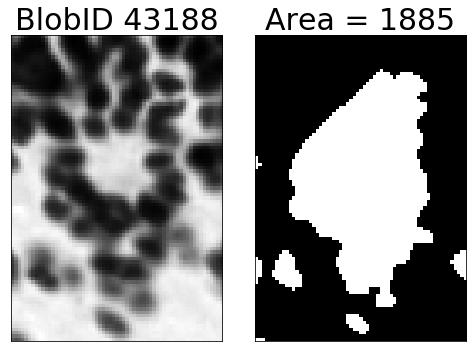

Blob ID 44047	 Area 1976.000000	 Compactness 2.299147	 Moments_hu_1 0.239827	 Moments_hu_2 0.009510


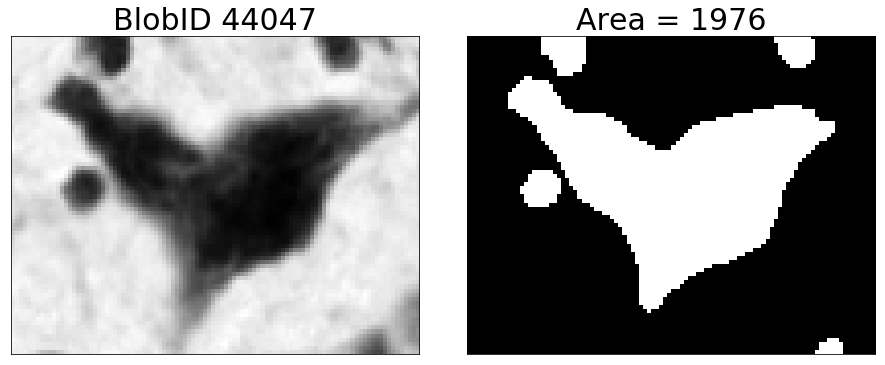

Blob ID 44859	 Area 3270.000000	 Compactness 2.421805	 Moments_hu_1 0.233255	 Moments_hu_2 0.022747


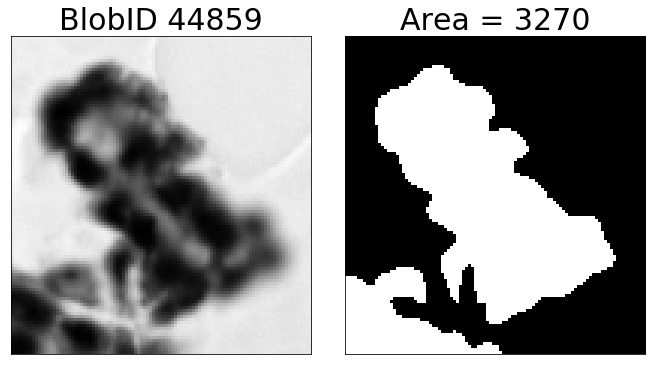

Blob ID 45314	 Area 1353.000000	 Compactness 2.321012	 Moments_hu_1 0.288163	 Moments_hu_2 0.039100


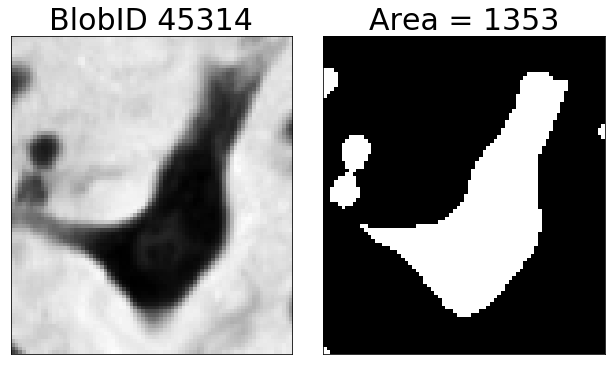

Blob ID 45884	 Area 1133.000000	 Compactness 2.282406	 Moments_hu_1 0.203849	 Moments_hu_2 0.007753


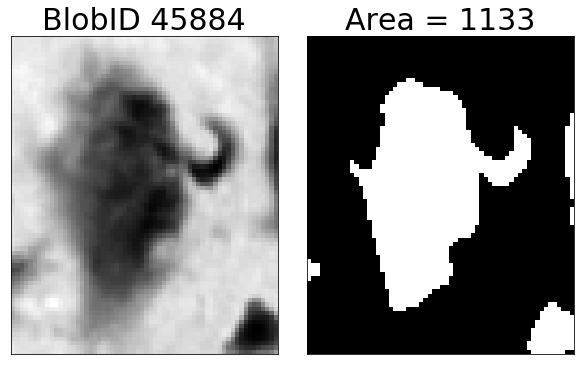

Blob ID 46016	 Area 1339.000000	 Compactness 2.200194	 Moments_hu_1 0.250516	 Moments_hu_2 0.022042


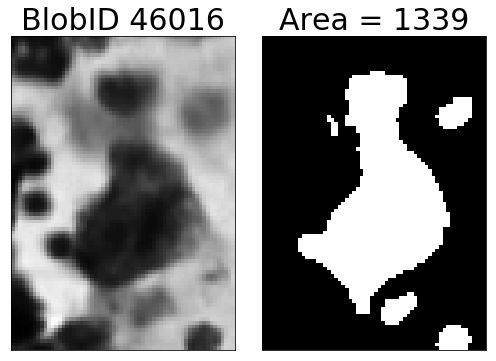

Blob ID 46956	 Area 1870.000000	 Compactness 2.045402	 Moments_hu_1 0.214790	 Moments_hu_2 0.015072


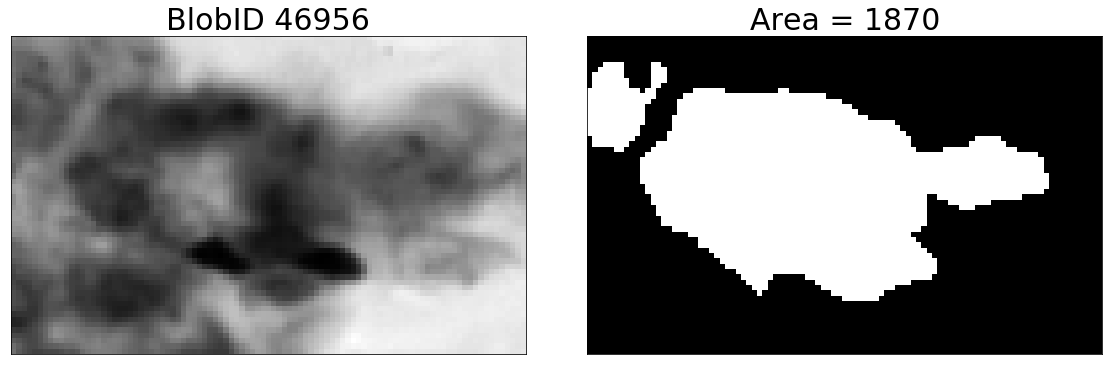

Blob ID 47579	 Area 1893.000000	 Compactness 2.116999	 Moments_hu_1 0.209559	 Moments_hu_2 0.012026


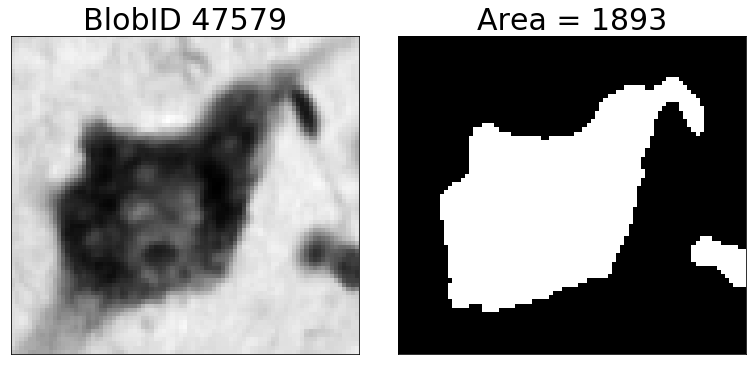

Blob ID 47602	 Area 2846.000000	 Compactness 2.460158	 Moments_hu_1 0.225887	 Moments_hu_2 0.017183


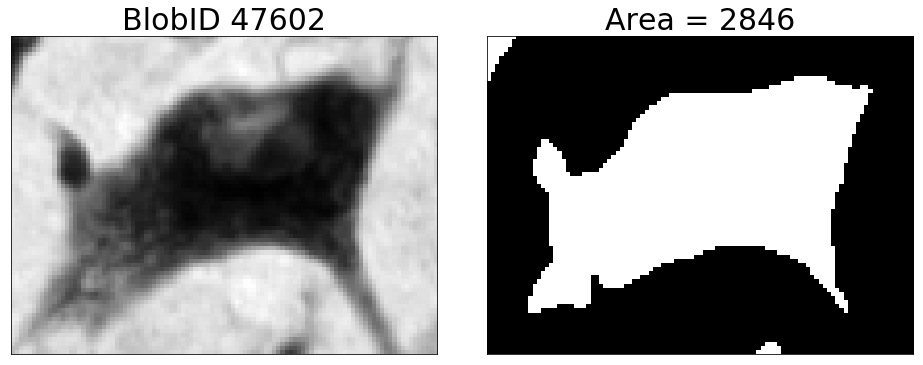

Blob ID 48492	 Area 1309.000000	 Compactness 2.430716	 Moments_hu_1 0.237414	 Moments_hu_2 0.017769


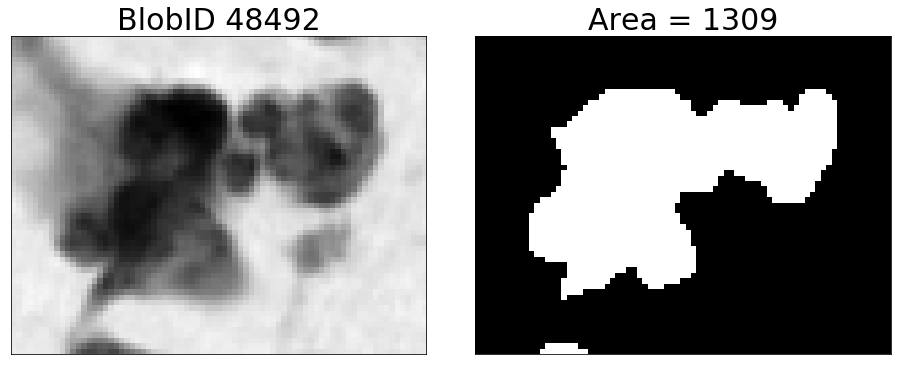

Blob ID 50572	 Area 1474.000000	 Compactness 2.442986	 Moments_hu_1 0.201040	 Moments_hu_2 0.003696


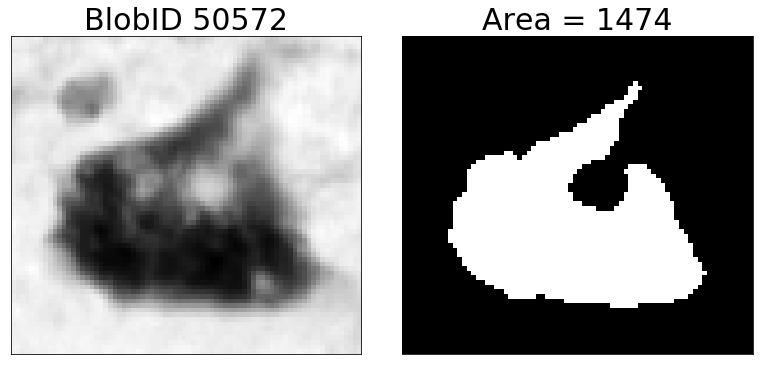

Blob ID 51933	 Area 1035.000000	 Compactness 2.421531	 Moments_hu_1 0.317460	 Moments_hu_2 0.067734


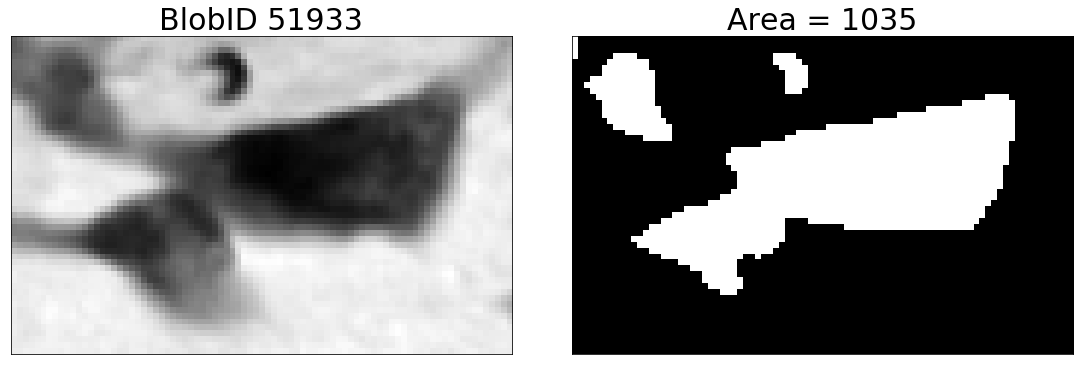

Blob ID 52463	 Area 1322.000000	 Compactness 2.310646	 Moments_hu_1 0.202001	 Moments_hu_2 0.005265


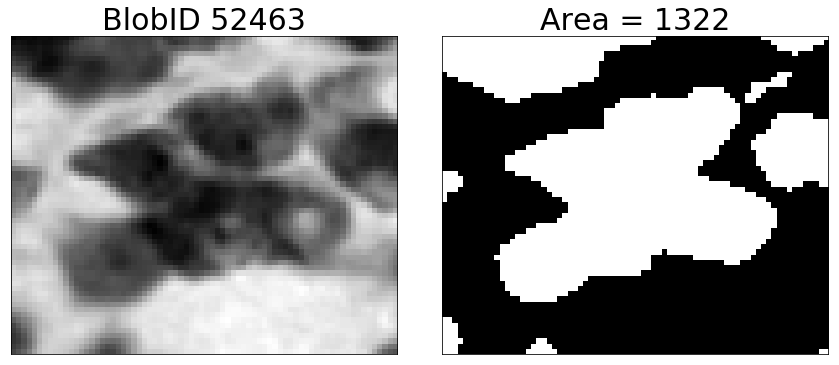

Blob ID 54169	 Area 2135.000000	 Compactness 2.351570	 Moments_hu_1 0.286446	 Moments_hu_2 0.052238


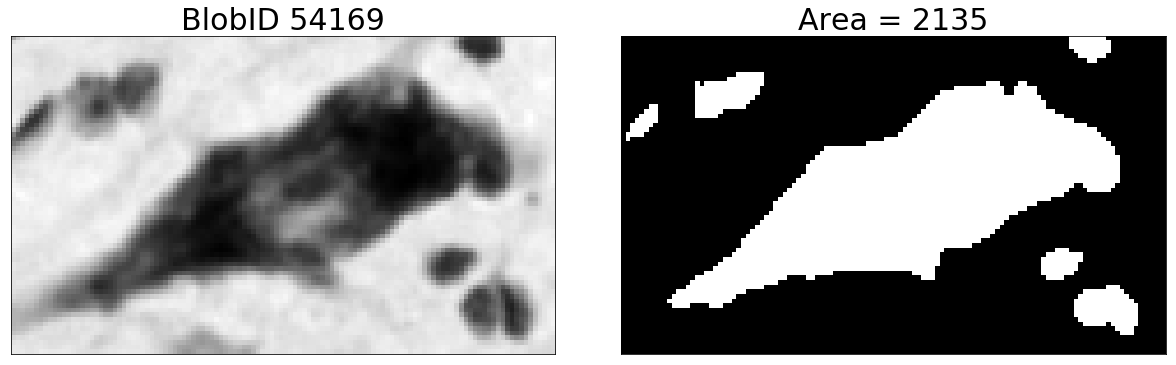

Blob ID 54300	 Area 1066.000000	 Compactness 2.185294	 Moments_hu_1 0.276046	 Moments_hu_2 0.037378


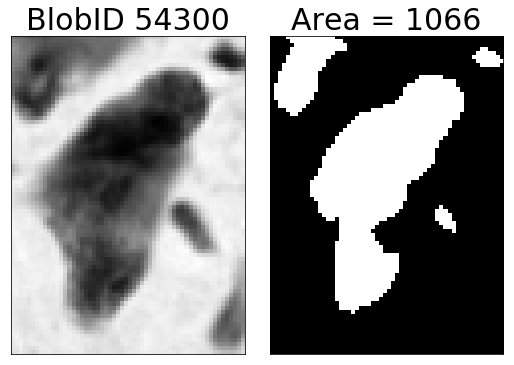

Blob ID 56220	 Area 1064.000000	 Compactness 2.345651	 Moments_hu_1 0.209232	 Moments_hu_2 0.007885


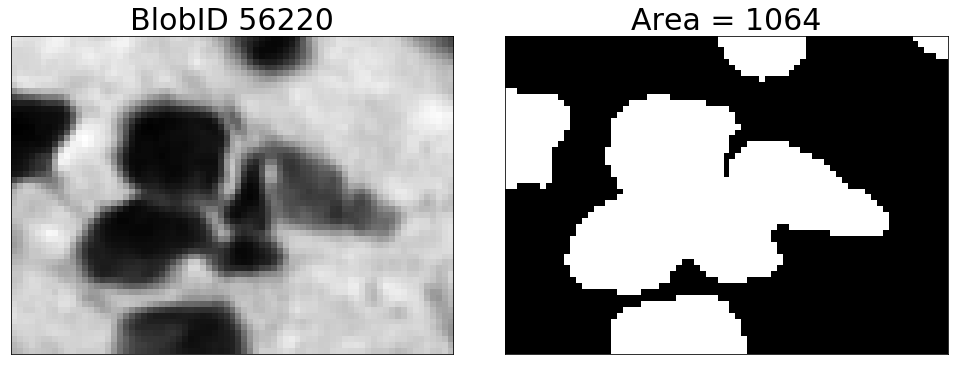

Blob ID 56337	 Area 1114.000000	 Compactness 2.456435	 Moments_hu_1 0.264111	 Moments_hu_2 0.040117


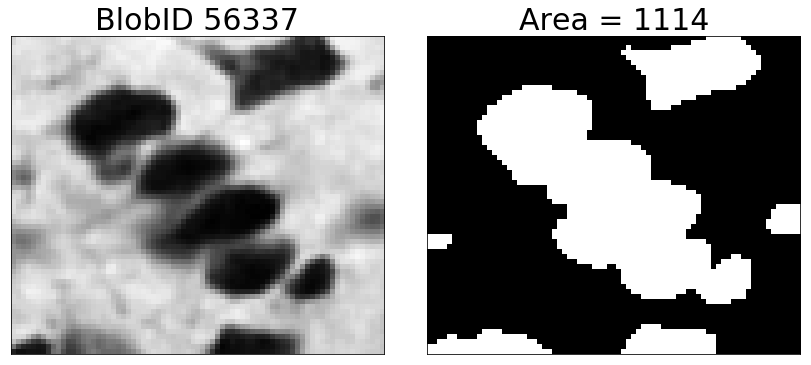

Blob ID 56526	 Area 1240.000000	 Compactness 2.330195	 Moments_hu_1 0.216061	 Moments_hu_2 0.011621


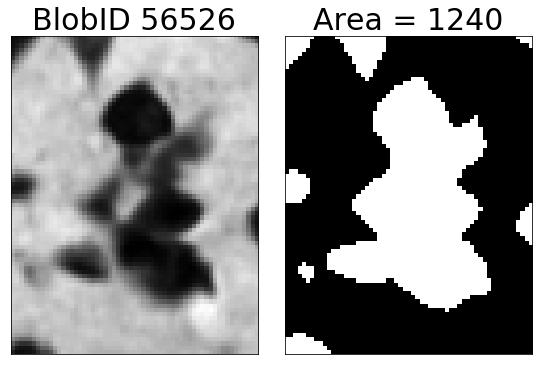

Blob ID 57259	 Area 1291.000000	 Compactness 2.023769	 Moments_hu_1 0.245449	 Moments_hu_2 0.027443


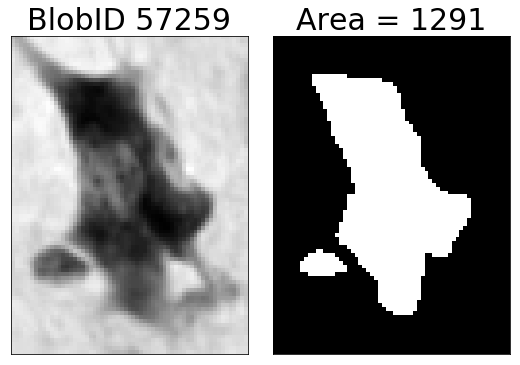

Blob ID 57285	 Area 1069.000000	 Compactness 2.186097	 Moments_hu_1 0.214737	 Moments_hu_2 0.005312


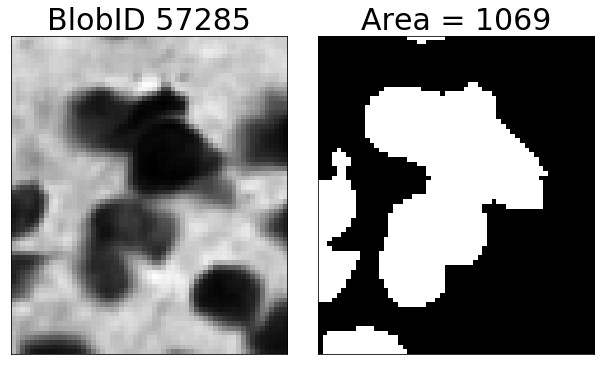

Blob ID 57653	 Area 1230.000000	 Compactness 2.124135	 Moments_hu_1 0.265943	 Moments_hu_2 0.041053


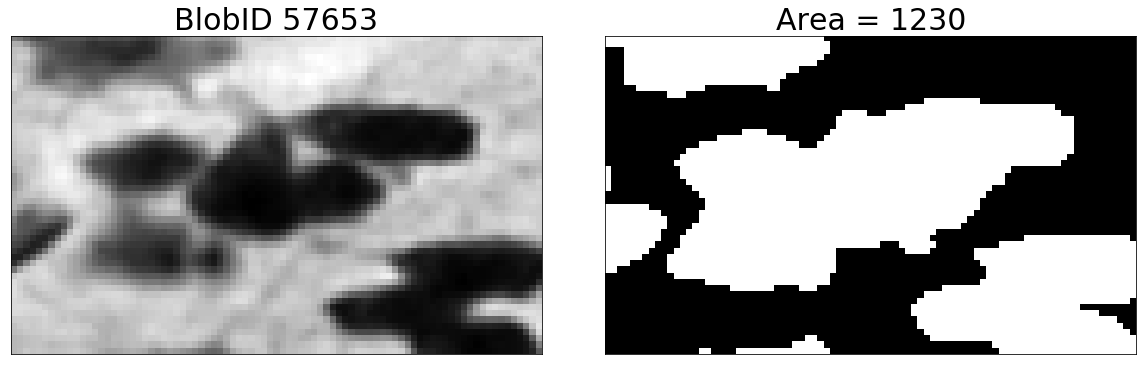

Blob ID 57873	 Area 1106.000000	 Compactness 2.443981	 Moments_hu_1 0.248118	 Moments_hu_2 0.027431


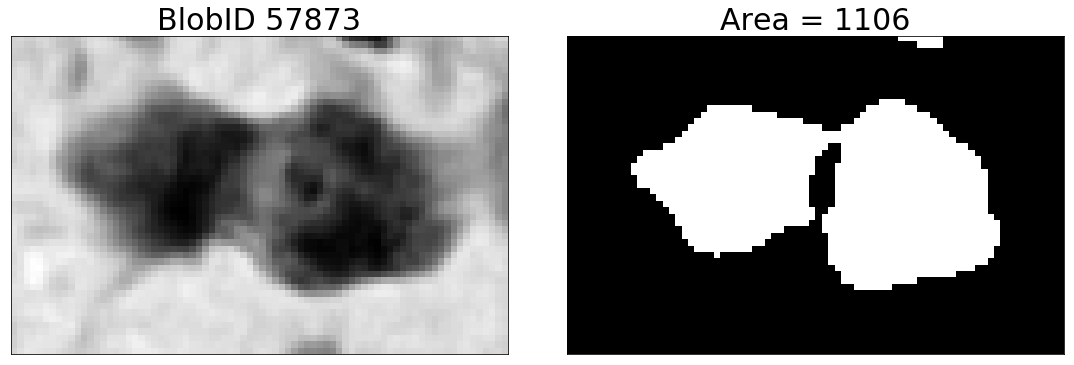

Blob ID 57927	 Area 1025.000000	 Compactness 2.138307	 Moments_hu_1 0.255375	 Moments_hu_2 0.036458


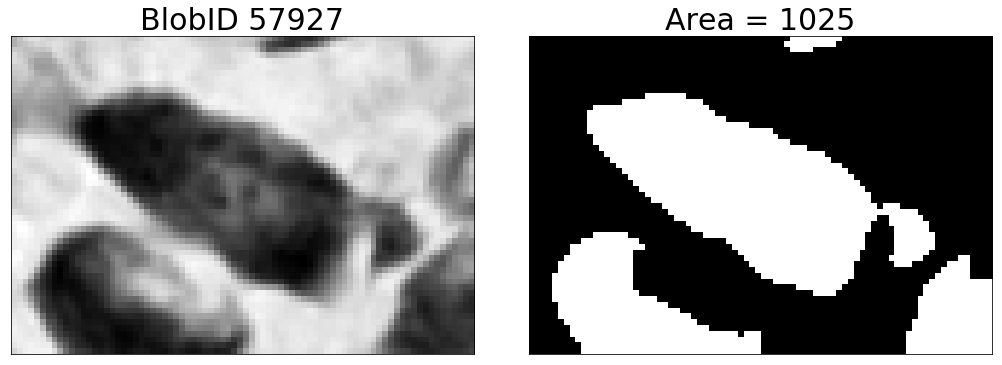

Blob ID 58380	 Area 1019.000000	 Compactness 2.365027	 Moments_hu_1 0.206009	 Moments_hu_2 0.006092


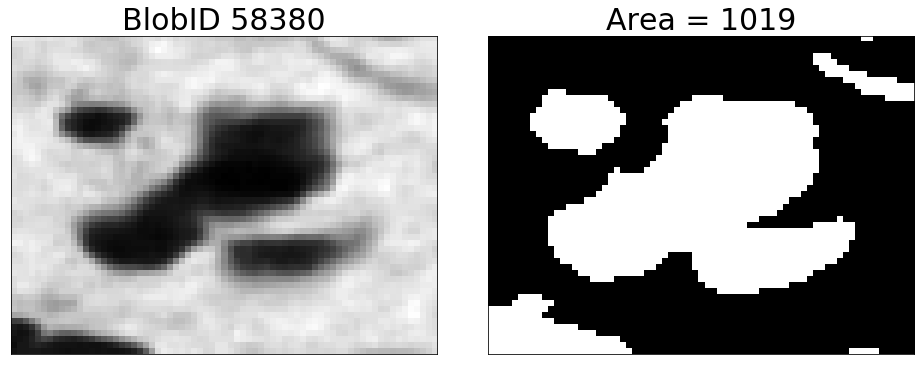

Blob ID 63348	 Area 1091.000000	 Compactness 2.305365	 Moments_hu_1 0.356479	 Moments_hu_2 0.096432


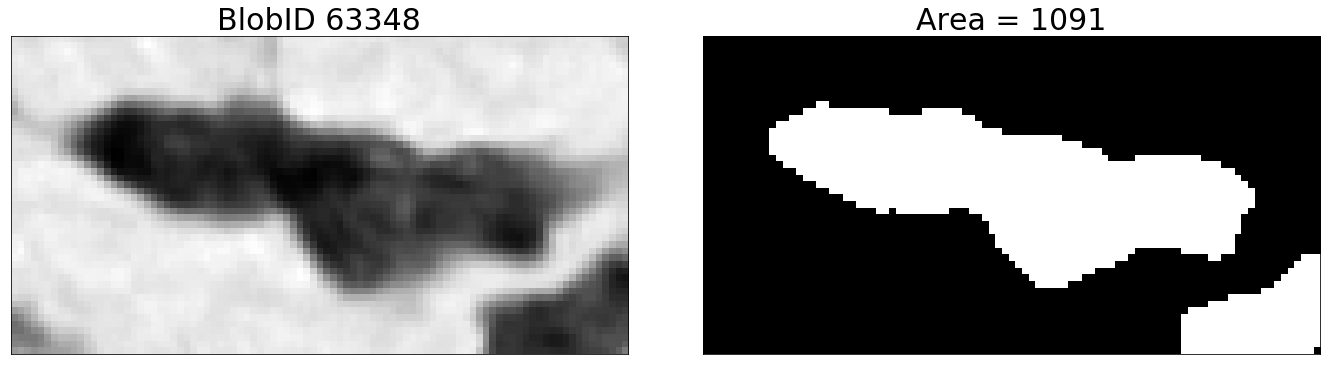

Blob ID 65328	 Area 1308.000000	 Compactness 2.299407	 Moments_hu_1 0.205330	 Moments_hu_2 0.004010


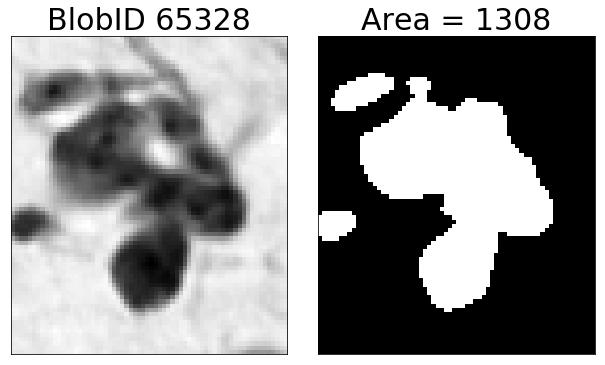

In [224]:
margin = 10
# for blobID in np.random.choice(tempIdx_cpL50_AS1000,10):
for blobID in tempIdx_cpL50_AS1000:
    print('Blob ID %d\t Area %f\t Compactness %f\t Moments_hu_1 %f\t Moments_hu_2 %f'%(blobID, blob_prop_dic['area'][blobID],blob_prop_dic['compactness'][blobID], blob_prop_dic['moments_hu'][blobID,0], blob_prop_dic['moments_hu'][blobID,1]))
    display_images_in_grids([fun_crop_images(im_cropped[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max),
                            fun_crop_images(im_BW[secIdx],*im_blob_prop[sec][blobID]['bbox'],margin=margin, im0max=im0max, im1max=im1max)]
                            ,nc=2, cmap=plt.cm.gray, titles=['BlobID %d'%blobID,'Area = %d'%im_blob_prop[sec][blobID]['area']])


In [219]:
# plt.figure(figsize=(15,15))
# plt.imshow(fun_crop_images(im_cropped[secIdx],*im_blob_prop[sec][44558]['bbox'],margin=100, im0max=im0max, im1max=im1max),cmap=plt.cm.gray)


# Find threshold to eliminate small blobs

1. How to quantify how many information the small blobs have? Does the properties of small blobs we used for typical blobs collections varies from one structure to another structure? If not, then for collecting typical blobs, we can just eliminate the small blobs. 

2. We can take care of the spatial organization of small blobs later, using some other features